In [39]:
%matplotlib widget

import sys
import os.path as op
from glob import glob

import numpy as np
from scipy.io import loadmat
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import mne
from mne.io import read_epochs_eeglab
from mne.decoding import SSD
from mne.time_frequency import psd_array_multitaper

In [56]:
def fit_ssd(data, info):
    """Alpha-band Spatio-Spectral Decomposition (SSD) from raw data"""
    #freqs_sig = 9, 14  # alpha
    #freqs_noise = 8, 15  # alpha
    freqs_sig = 15, 29  # beta
    freqs_noise = 14, 30  # beta
    # freqs_sig = 35, 45  # gamma
    # freqs_noise = 30, 50  # gamma

    ssd = SSD(info=info,
              reg='oas',
              sort_by_spectral_ratio=True,
              filt_params_signal=dict(l_freq=freqs_sig[0],
                                      h_freq=freqs_sig[1],
                                      l_trans_bandwidth=1,
                                      h_trans_bandwidth=1),
              filt_params_noise=dict(l_freq=freqs_noise[0],
                                     h_freq=freqs_noise[1],
                                     l_trans_bandwidth=1,
                                     h_trans_bandwidth=1))
    data_filtered = ssd.fit_transform(X=data)
    return data_filtered, ssd


def read_data(subj_id, series_num, data_dir, pick_channels=None):
    # read in both pre- and post-TMS sessions belonging to a single subject
    series_num = str(series_num)
    subj_id = subj_id.zfill(4)
    fname_t1 = op.join(data_dir, 'series_' + series_num, 'T1/preprocessed',
                       subj_id + '_Pre_Session1_Series' + series_num + '_Preprocessed.set')
    fname_t2 = op.join(data_dir, 'series_' + series_num, 'T2/preprocessed',
                       subj_id + '_Post_Session1_Series' + series_num + '_Preprocessed.set')

    # read in data
    epochs_pre_post = list()
    for fname in [fname_t1, fname_t2]:
        epochs = read_epochs_eeglab(fname)
        if pick_channels is not None:
            epochs = epochs.pick_channels(pick_channels)
        epochs_data = epochs.get_data().squeeze()
        #epochs_data -= np.mean(epochs_data, axis=(1, 2), keepdims=True)
        #epochs_data /= np.std(epochs_data, axis=(1, 2), keepdims=True)
        epochs_pre_post.append(epochs_data)
    epochs_info = epochs.info  # save for fit_ssd()
    epoch_times = epochs.times  # save save for spec_event_coherence_shift()
    
    return epochs_pre_post, epochs_info, epoch_times


def spatio_spectral_shift(epochs_pre_post, epochs_info):
    ssd_weights = list()
    for sess_idx, epochs_data in enumerate(epochs_pre_post):
        filtered_data, ssd = fit_ssd(epochs_data, epochs_info)
        ssd_weights.append(ssd.patterns_[0])
    
    # compute stats across pre/post sessions
    ssd_std_diff = ssd_weights[1].std() - ssd_weights[0].std()
    ssd_weights_diff = ssd_weights[1] - ssd_weights[0]
    ssd_weights_diff_flip = ssd_weights[1] + ssd_weights[0]
    # note that some subjects have sessions where the spatial SSD pattern
    # remains consistent, but with opposite sign
    # given that an opposite sign of an SSD weight reflects a pi-radians phase
    # difference, here I explored the possibility that the sign assigned to a
    # given SSD vector is somewhat arbitrary by taking the SSD weight
    # difference with minimal magnitude
    ssd_norm = min(np.sqrt(np.mean(ssd_weights_diff ** 2)),
                   np.sqrt(np.mean(ssd_weights_diff_flip ** 2)))

    return ssd_std_diff, ssd_norm


def spec_event_coherence_shift(epochs_pre_post, times):
    # set path to SpectralEvents
    sys.path.append('/users/rthorpe/brainstorm-ws/spectral-events')
    import spectralevents as se
    
    event_band = [15, 29]  # beta band (Hz)
    thresh_FOM = 6.0  # factor-of-the-median threshold

    dt = times[1] - times[0]
    samp_freq = 1 / dt
    freqs = freqs = range(3, 40)
    
    time_bin = 0.05  # 50 ms
    binned_times = np.arange(0, times[-1] + time_bin, time_bin)
    n_bins = len(binned_times)
    
    pre_post_coherence = list()
    for epochs_data in epochs_pre_post:
        n_epochs = epochs_data.shape[0]
        n_chans = epochs_data.shape[1]
        event_raster = list()
        for chan_idx in range(n_chans):
            chan_events = np.zeros((n_epochs, n_bins))  # to store binary event flags
            chan_epochs_data = epochs_data[:, chan_idx, :].squeeze()
            
            # compute TFRs
            tfrs = se.tfr(chan_epochs_data, freqs, samp_freq)
            # find events
            spec_events = se.find_events(tfr=tfrs, times=times, freqs=freqs,
                                         event_band=event_band, threshold_FOM=6.)
            
            n_events = [len(epoch_events) for epoch_events in spec_events]
            print(f'Found {sum(n_events)} beta events in current channel.')
            for epoch_idx, epoch_events in enumerate(spec_events):
                for event in epoch_events:
                    bin_idx = np.nonzero(binned_times > event['Peak Time'])[0]
                    chan_events[epoch_idx, bin_idx] = 1
            event_raster.append(chan_events)
        sess_coherence = np.mean(event_raster[0] * event_raster[1])
        print(f'Mean inter-hemisphere beta event coherence for current session: {sess_coherence}.')
        pre_post_coherence.append(sess_coherence)
    
    return pre_post_coherence[1] - pre_post_coherence[0]


def get_features(subj_id, series_num, data_dir):
    epochs_pre_post, epochs_info, _ = read_data(subj_id, series_num, data_dir)
    ssd_std_diff, ssd_norm = spatio_spectral_shift(epochs_pre_post, epochs_info)
    
    epochs_pre_post_c3_c4, _, times = read_data(subj_id, series_num, data_dir, pick_channels=['C3', 'C4'])
    spec_event_coherence_diff = spec_event_coherence_shift(epochs_pre_post_c3_c4, times)
    
    return ssd_std_diff, ssd_norm, spec_event_coherence_diff

In [5]:
# set data directory
data_dir = '/gpfs/data/brainstorm-ws/data/'
data_type = 'TRAINING'

In [6]:
# read metadata from master list
fname_master = op.join(data_dir, data_type, data_type + '_Master List_All Series.csv')
master_keys = np.loadtxt(fname_master,  delimiter=',', max_rows=1, dtype=str)
master_keys[0] = 'TMSID'  # fix first key string
master_values = np.loadtxt(fname_master, delimiter=',', skiprows=1, dtype=str)
master_info = {key: master_values[:, master_keys == key].squeeze() for key in master_keys}

# get subject IDs for subject series with both pre-/post-TMS EEG recordings
subj_select = master_info['HasT1T2'] == '1'
subj_ids = master_info['TMSID'][subj_select]
n_series_recordings = sum(subj_select)

In [7]:
# read metadata from demographics and clinical outcomes
fname_outcomes = op.join(data_dir, data_type, data_type + '_Demographics and Clinical Outcomes_All Series.csv')
outcomes_keys = np.loadtxt(fname_outcomes,  delimiter=',', max_rows=1, dtype=str)
outcomes_keys[0] = 'TMSID'  # fix first key string
outcomes_values = np.loadtxt(fname_outcomes, delimiter=',', skiprows=1, dtype=str)
outcome_info = {key: outcomes_values[:, outcomes_keys == key].squeeze() for key in outcomes_keys}

# get demographic and outcome data for each subject series
ages = outcome_info['AgeTMSstart'][subj_select].astype(int)
sexes = outcome_info['Sex'][subj_select].astype(int)
depression_histories = outcome_info['SevHxDep'][subj_select].astype(int)
responders = outcome_info['LastRespIDSSR'][subj_select].astype(int)

# get series number for each subject series
series_nums = outcome_info['Series'][subj_select].astype(int)

In [57]:
# test analysis pipeline
data_type_dir = op.join(data_dir, data_type)
ssd_std_diff, ssd_norm, spec_event_coherence_diff = get_features(subj_ids[0], series_nums[0], data_type_dir)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found


/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.8s finished


    Using tolerance 5.1e-12 (2.2e-16 eps * 64 dim * 3.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Computing rank from data with rank=None


[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.9s finished


    Using tolerance 5.3e-12 (2.2e-16 eps * 64 dim * 3.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0026_Pre_Session1_Series3_Preprocessed.set...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0026_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
86 matching events found
No baseline correction applied
0 projection items activated
Ready.


/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs = read_epochs_eeglab(fname)


Found 378 beta events in current channel.
Found 351 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.6410376621347086.
Found 370 beta events in current channel.
Found 345 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5420614412862474.


In [58]:
# run spatio-spectral decomposition analysis
# use embarrassingly parallel loop across subject series to speed things up
n_jobs = 12
data_type_dir = op.join(data_dir, data_type)
out = Parallel(n_jobs=n_jobs)(delayed(get_features)(subj_ids[idx], series_nums[idx], data_type_dir)
                              for idx in range(n_series_recordings))
ssd_std_diffs, ssd_norms, spec_event_coherence_diffs = zip(*out)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0246_Pre_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0256_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0116_Pre_Session1_Series3_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0249_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0250_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0255_Post_Session1_Series1_Preprocessed.set...
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
No baseline correction applied
0 projection items activated
Ready.
Ready.
Not setting metadata
67 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_4/T2/preprocessed/0091_Post_Session1_Series4_Preprocessed.set...
Setting up band-pass 

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 H

    Using tolerance 4.5e-12 (2.2e-16 eps * 64 dim * 3.2e+02  max singular value)
Effective window size : 1.000 (s)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 2.6e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Reducing data rank f

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0192_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
25 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0192_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
79 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff 

Not setting metadata
56 matching events found
No baseline correction applied
0 projection items activated
Ready.
Found 96 beta events in current channel.
Found 99 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.654320987654321.
Found 370 beta events in current channel.
Found 384 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5397718393498985.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0265_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0265_Post_Session1_Series1_Preprocessed.set...
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
Not setting metadata
72 matching events found
No baseline correction applied
0 projec

Done.
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 5.9e-12 (2.2e-16 eps * 64 dim * 4.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
    U

Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0293_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
42 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 1.8e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
Extracting parameters from /gpf

Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 6.1e-12 (2.2e-16 eps * 64 dim * 4.3e+02  max singular value)
Computing rank from data with rank=None
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
Computing rank from data with rank=None

    Using tolerance 6.9e-12 (2.2e-16 eps * 64 dim * 4.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passb

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition

Computing rank from data with rank=None
    Using tolerance 1.8e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 94  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Done.
Found 267 beta events in current channel.
Found 328 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5648148148148148.
Found 241 beta events in current channel.
Found 292 b

Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0295_Pre_Session1_Series1_Preprocessed.set...
Done.
Not setting metadata
79 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0295_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
74 matching events found
Effective window size : 1.000 (s)
No baseline correction applied
0 p

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transit

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 1600 out of 1600 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Computing rank from data with rank=None
    Using tolerance 9.1e-12 (2.2e-16 eps * 64 dim * 6.4e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0296_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
86 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0296_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4608 out of 4608 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Reducing data rank from 64 -> 64
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Estimating covariance using OAS
Effective window size : 1.000 (s)
Done.
Computing rank from data with rank=None
Done.
Done.
Computing rank from data with rank=None
Effective window size : 1.000 (s)
    Using tolerance 1.7e-12 (2.2e-16 eps * 64 dim * 1.2e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 6.5e-12 (2.2e-16 eps * 64 dim * 4.6e+02  max singular value)
    Using tolerance 2.5e-12 (2.2e-16 eps * 64 dim * 1.8e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
Reducing data rank from 64 -> 64
R

    Using tolerance 1.8e-12 (2.2e-16 eps * 64 dim * 1.3e+02  max singular value)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors


/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Found 323 beta events in current channel.
Found 330 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.4789191707430701.
Found 269 beta events in current channel.
Found 270 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.4302402761184123.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0335_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0335_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
78 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR fil

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4352 out of 4352 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 H

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4800 out of 4800 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T1/preprocessed/0296_Pre_Session1_Series3_Preprocessed.set...
Not setting metadata
93 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_3/T2/preprocessed/0296_Post_Session1_Series3_Preprocessed.set...
Not setting metadata
121 matching events found
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5120 out of 5120 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

    Using tolerance 7.7e-12 (2.2e-16 eps * 64 dim * 5.4e+02  max singular value)
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
    Using tolerance 3.6e-12 (2.2e-16 eps * 64 dim * 2.5e+02  max singular value)
    Using tolerance 8.4e-12 (2.2e-16 eps * 64 dim * 5.9e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 7.9e-12 (2.2e-16 eps * 64 dim * 5.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 proje

    Using tolerance 5.6e-12 (2.2e-16 eps * 64 dim * 4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Found 327 beta events in current channel.
Found 327 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5608655250232312.
Found 308 beta events in current channel.
Found 266 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5633528265107213.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0341_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
77 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0341_Post_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Not setting metadata
87 matching events found
Estimating covariance u

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5696 out of 5696 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)



/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T1/preprocessed/0320_Pre_Session1_Series2_Preprocessed.set...
Not setting metadata
91 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0320_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
94 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 16

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5056 out of 5056 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 7.6e-13 (2.2e-16 eps * 64 dim * 54  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors


/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6144 out of 6144 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Done.
    Using tolerance 6.7e-12 (2.2e-16 eps * 64 dim * 4.7e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Computing rank from data with rank=None
Computing rank from data with rank=None
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6464 out of 6464 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Found 631 beta events in current channel.
Found 558 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.6237959571292905.
Found 564 beta events in current channel.
Found 501 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5902285263987391.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0355_Pre_Session1_Series1_Preprocessed.set...
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0335_Post_Session1_Series1_Preprocessed.set...
No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
78 matching events found
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0336_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
107 matching events found
Not setting metadata
42 matching events found
No baseline correction applied
0 projection i

    Using tolerance 2.3e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular value)
    Using tolerance 7.2e-12 (2.2e-16 eps * 64 dim * 5.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB c

/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6592 out of 6592 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining

Not setting metadata
97 matching events found
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency:

Done.
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
    Using tolerance 7.2e-12 (2.2e-16 eps * 64 dim * 5.1e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Found 315 beta events in current channel.
Found 299 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5341659488946311.
Found 331 beta events in current channel.
Found 353 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.6284538506760728.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0365_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
113 matching events found
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/br

Reducing data rank from 64 -> 64
Not setting metadata
94 matching events found
Estimating covariance using OAS
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Effective window size : 1.000 (s)
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Computing rank from data with rank=None
    Using tolerance 2.4e-12 (2.2e-16 eps * 64 dim * 1.7e+02  max singular 

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.1e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 1.6e-12 (2.2e-16 eps * 64 dim * 1.1e+02  max singular value)
    

Computing rank from data with rank=None
Found 401 beta events in current channel.
Found 423 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5634014076381678.
Found 472 beta events in current channel.
Found 290 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.48743645606390706.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0372_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0372_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase,

No baseline correction applied
0 projection items activated
Ready.
Not setting metadata
116 matching events found
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Estimating covariance using OAS
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0357_Post_Session1_Series1_Preprocessed.set...
Done.
Not setting metadata
123 matching events found


No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0365_Post_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Not setting metadata
100 matching events found
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

No baseline correction applied
0 projection items activated
Ready.
Computing rank from data with rank=None
Done.
Computing ran

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4992 out of 4992 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Found 351 beta events in current channel.
Found 380 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5186205489235792.
Found 349 beta events in current channel.
Found 347 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5274277714140257.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Done.
Estimating covariance using OAS
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
-------------------

Reducing data rank from 64 -> 64
Not setting metadata
78 matching events found
Not setting metadata
107 matching events found
Estimating covariance using OAS
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
No baseline correction applied
0 projection items activated
Ready.
Ready.
Estimating covariance using OAS
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0370_Post_Session1_Series1_Preprocessed.set...
    Using tolerance 2.7e-12 (2.2e-16 eps * 64 dim * 1.9e+02  max singular value)
Computing rank from data with rank=None
Not setting metadata
105 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Done.
    Using tolerance 2.3e-12 (2.2e-16 eps * 64 dim * 1.6e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4864 out of 4864 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandw

Done.
    Using tolerance 3.6e-12 (2.2e-16 eps * 64 dim * 2.6e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0401_Post_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
90 matching events found
Done.
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6144 out of 6144 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

    Using tolerance 9.5e-12 (2.2e-16 eps * 64 dim * 6.7e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0407_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covari

Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0413_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
97 matching events found
Computing rank from data with rank=None
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6016 out of 6016 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

Computing rank from data with rank=None
    Using tolerance 4.8e-12 (2.2e-16 eps * 64 dim * 3.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Done.
    Using tolerance 3.4e-12 (2.2e-16 eps * 64 dim * 2.4e+02  max singular value)
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pa

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5184 out of 5184 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

    Using tolerance 1.6e-11 (2.2e-16 eps * 64 dim * 1.1e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
Estimating covariance using OAS
    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 92  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels wi

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4800 out of 4800 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 9.6e-12 (2.2e-16 eps * 64 dim * 6.8e+02  max singular value)
Computing rank from data with rank=None
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Effective window size : 1.000 (s)
Done.
Setting up ban

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4992 out of 4992 | elapsed:    1.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.6s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

Computing rank from data with rank=None
Done.
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0390_Pre_Session1_Series1_Preprocessed.set...
Computing rank from data with rank=None
Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/s

Ready.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_2/T2/preprocessed/0419_Post_Session1_Series2_Preprocessed.set...
Not setting metadata
81 matching events found
Reducing data rank from 64 -> 64
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Estimating covariance using OAS
Effective window size : 1.000 (s)
Done.
Don

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 4736 out of 4736 | elapsed:    1.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

No baseline correction applied
0 projection items activated
Ready.
Done.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)



[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5824 out of 5824 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

Computing rank from data with rank=None
    Using tolerance 4.3e-12 (2.2e-16 eps * 64 dim * 3.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:

    Using tolerance 6.3e-12 (2.2e-16 eps * 64 dim * 4.4e+02  max singular value)
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Effective window size : 1.000 (s)
Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0407_Pre_Session1_Series1_Preprocessed.set...
Reducing data rank from 64 -> 64
Computing rank from data with rank=None
Estimating covariance using OAS
Not setting metadata
119 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0407_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Done.
Computing rank from data with rank=None
    Using tolerance 1.1e-11 (2.2e-16 eps * 64 dim * 7.5e+02 

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Found 307 beta events in current channel.
Found 255 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5328214393255044.
Found 181 beta events in current channel.
Found 245 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.4046639231824417.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 6720 out of 6720 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

    Using tolerance 1.3e-12 (2.2e-16 eps * 64 dim * 94  max singular value)
Reducing data rank from 64 -> 64
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Estimating covariance using OAS
Reducing data rank from 64 -> 64
    Using tolerance 7.2e-13 (2.2e-16 eps * 64 dim * 50  max singular value)
Estimating covariance using OAS
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Computing rank from data with rank=None
Done.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Effective window size : 1.000 (s)
Done.
Effective window size : 1.000 (s)
Computing rank from data with rank=None
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5376 out of 5376 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lo

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

    Using tolerance 5.1e-12 (2.2e-16 eps * 64 dim * 3.6e+02  max singular value)
Done.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 4.7e-12 (2.2e-16 eps * 64 dim * 3.3e+02  max singular value)
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter

Done.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0419_Pre_Session1_Series1_Preprocessed.set...
Effective window size : 1.000 (s)
    Using tolerance 2.9e-12 (2.2e-16 eps * 64 dim * 2e+02  max singular value)
Not setting metadata
101 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0419_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
Reducing data rank from 64 -> 64
Estimating covariance using OAS
    Using tolerance 3.4e-12 (2.2e-16 eps * 64 dim * 2.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Using tolerance 5.1e-12 (2.2e-16 eps * 

Computing rank from data with rank=None
    Using tolerance 1.9e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 8768 out of 8768 | elapsed:    3.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
/tmp/ipykernel_3278/3971197178.py:37: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
[Parallel(n_jobs=1)]: Usi

Reducing data rank from 64 -> 64
Estimating covariance using OAS
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upp

Done.
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Found 323 beta events in current channel.
Found 325 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.549526270456503.
Found 184 beta events in current channel.
Found 172 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.5432098765432098.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0467_Pre_Session1_Series1_Preprocessed.set...

No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0431_Post_Session1_Series1_Preprocessed.set...
Done.
Not setting metadata
82 matching events found
Done.
No baseline correction applied
0 projection items activated
Ready.
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
    Using tolerance 5.8e-12 (2.2e-16 eps * 64 dim * 4.1e+02  max singular value)
    Using tolerance 2e-12 (2.2e-16 eps * 64 dim * 1.4e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Found 318 beta events in current channel.
Found 301 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.6158594491927826.
Found 522 beta events in current channel.
Found 382 beta events in current channel.


Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 

No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Done.
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Computing rank from data with rank=None
Found 353 beta events in current channel.
Found 354 beta events in current channel.
Mean inter-hemisphere beta event coherence for current session: 0.653874758292429.
Found 312 beta events in current chan

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5312 out of 5312 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5312 out of 5312 | elapsed:    1.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

No baseline correction applied
0 projection items activated
Ready.
No baseline correction applied
0 projection items activated
Ready.
Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6

    Using tolerance 7e-12 (2.2e-16 eps * 64 dim * 5e+02  max singular value)
    Using tolerance 3e-12 (2.2e-16 eps * 64 dim * 2.1e+02  max singular value)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0466_Post_Session1_Series1_Preprocessed.set...
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Not setting metadata
76 matching events found
No baseline correction applied
0 projection items activated
Ready.
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0461_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
92 matching events found
Extracting parameters from /gpfs/data/brains

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 15 - 29 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 14.50 Hz)
- Upper passband edge: 29.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 29.50 H

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 5504 out of 5504 | elapsed:    1.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  

Computing rank from data with rank=None
Computing rank from data with rank=None
Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 30.50 Hz)
- Filter length: 1651 samples (3.302 sec)

Setting up band-pass filter from 14 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 14.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Upper passband edge:

Computing rank from data with rank=None
    Using tolerance 7.2e-12 (2.2e-16 eps * 64 dim * 5.1e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Computing rank from data with rank=None
    Using tolerance 2.2e-12 (2.2e-16 eps * 64 dim * 1.5e+02  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using OAS
Done.
Effective window size : 1.000 (s)
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_6/T1/preprocessed/9001_Pre_Session1_Series6_Preprocessed.set...
Not setting metadata
83 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_6/T2/preprocessed/9001_Post_Session1_Series6_Preprocessed.set...
Not 

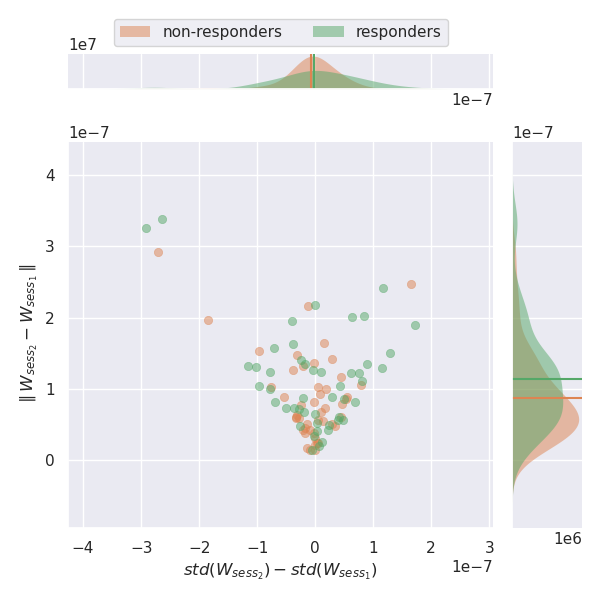

In [59]:
g = sns.JointGrid()

for class_idx, class_ in enumerate(set(responders)):
    if class_ == 1:
        label = 'responders'
    else:
        label = 'non-responders'
    cluster_mask = labels_all == class_
    x = np.array(ssd_std_diffs)[cluster_mask]
    y = np.array(ssd_norms)[cluster_mask]
    
    # plot data points for a given class label (i.e., responder or non-responder)
    sns.scatterplot(x=x, y=y, alpha=.5, edgecolor=None,
                    color=f'C{class_idx + 1}', ax=g.ax_joint)
    
    # plot marginal distributions for a given class label
    sns.kdeplot(x=x, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
    g.ax_marg_x.axvline(np.mean(x), color=f'C{class_idx + 1}')
    sns.kdeplot(y=y, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_y)
    g.ax_marg_y.axhline(np.mean(y), color=f'C{class_idx + 1}')
    
    
g.ax_joint.set_xlabel(r'$std(W_{sess_2})-std(W_{sess_1})$')
g.ax_joint.set_ylabel(r'$\parallel W_{sess_2}-W_{sess_1}\parallel$')
g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
g.fig.tight_layout()

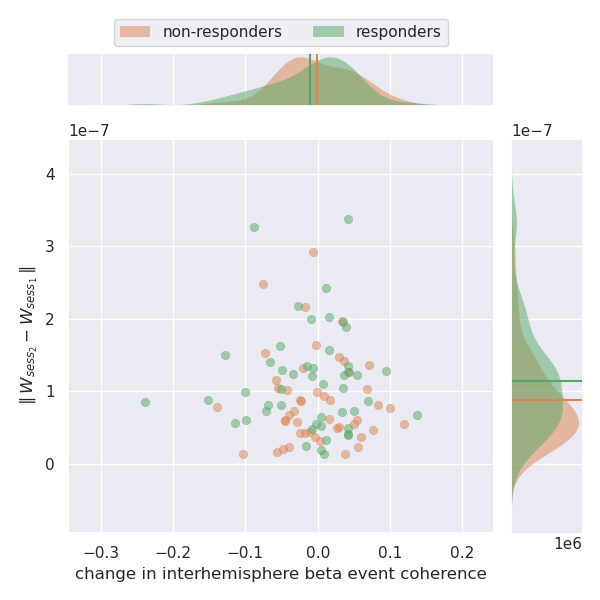

In [61]:
g = sns.JointGrid()

for class_idx, class_ in enumerate(set(responders)):
    if class_ == 1:
        label = 'responders'
    else:
        label = 'non-responders'
    cluster_mask = labels_all == class_
    x = np.array(spec_event_coherence_diffs)[cluster_mask]
    y = np.array(ssd_norms)[cluster_mask]
    
    # plot data points for a given class label (i.e., responder or non-responder)
    sns.scatterplot(x=x, y=y, alpha=.5, edgecolor=None,
                    color=f'C{class_idx + 1}', ax=g.ax_joint)
    
    # plot marginal distributions for a given class label
    sns.kdeplot(x=x, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_x, label=label)
    g.ax_marg_x.axvline(np.mean(x), color=f'C{class_idx + 1}')
    sns.kdeplot(y=y, bw_adjust=0.85, fill=True, linewidth=0, alpha=.5,
                color=f'C{class_idx + 1}', ax=g.ax_marg_y)
    g.ax_marg_y.axhline(np.mean(y), color=f'C{class_idx + 1}')
    
    
g.ax_joint.set_xlabel(f'change in interhemisphere beta event coherence')
g.ax_joint.set_ylabel(r'$\parallel W_{sess_2}-W_{sess_1}\parallel$')
g.ax_marg_x.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, 1.02))
g.fig.tight_layout()

In [40]:
# read in data from from example subject series
data_dir = '/gpfs/data/brainstorm-ws/data/TRAINING/series_1/'
subj_id = '0372'
t1_fname = op.join(data_dir, 'T1/preprocessed', subj_id + '_Pre_Session1_Series1_Preprocessed.set')
t2_fname = op.join(data_dir, 'T2/preprocessed', subj_id + '_Post_Session1_Series1_Preprocessed.set')

epochs_t1 = read_epochs_eeglab(t1_fname)
epochs_t2 = read_epochs_eeglab(t2_fname)

# choose C3 EEG channel data
epochs_t1 = epochs_t1.pick_channels(['C3'])
epochs_t2 = epochs_t2.pick_channels(['C3'])

# investigate PSD
plt.close('all')
fig, ax = plt.subplots(1, 1)

epochs_t1.plot_psd(fmin=3., fmax=50., ax=ax, color='orange', spatial_colors=False)
epochs_t2.plot_psd(fmin=3., fmax=50., ax=ax, color='blue', spatial_colors=False)
    
plt.show()

# get epoch data
data_t1 = epochs_t1.get_data().squeeze()  # epoch x time
data_t2 = epochs_t2.get_data().squeeze()  # epoch x time

times = epochs_t1.times
dt = times[1] - times[0]
samp_freq = 1 / dt
print(np.array_equal(epochs_t1.times, epochs_t2.times))

Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T1/preprocessed/0372_Pre_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found
No baseline correction applied
0 projection items activated
Ready.
Extracting parameters from /gpfs/data/brainstorm-ws/data/TRAINING/series_1/T2/preprocessed/0372_Post_Session1_Series1_Preprocessed.set...
Not setting metadata
81 matching events found


/tmp/ipykernel_209948/3047747553.py:6: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs_t1 = read_epochs_eeglab(t1_fname)
/tmp/ipykernel_209948/3047747553.py:7: RuntimeWarning: At least one epoch has multiple events. Only the latency of the first event will be retained.
  epochs_t2 = read_epochs_eeglab(t2_fname)


No baseline correction applied
0 projection items activated
Ready.


In [51]:
a = [[[1,2], [3,4]],[[5,6], [7,8]]]
[[inner[0] for inner in outer] for outer in a]

[[1, 3], [5, 7]]